In [1]:
import json
import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator

from pathlib import Path

In [2]:
l5pc_cell = model.create()

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]

fitness_protocols = evaluator.define_protocols()

fitness_calculator = evaluator.define_fitness_calculator(
    fitness_protocols,
    feature_file=Path("./config/features.json"),
    feature_set='soma'
)

sim = ephys.simulators.NrnSimulator()

eva = ephys.evaluators.CellEvaluator(                    
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)

In [3]:
responses = eva.run_protocols(protocols=fitness_protocols.values(), param_values={})

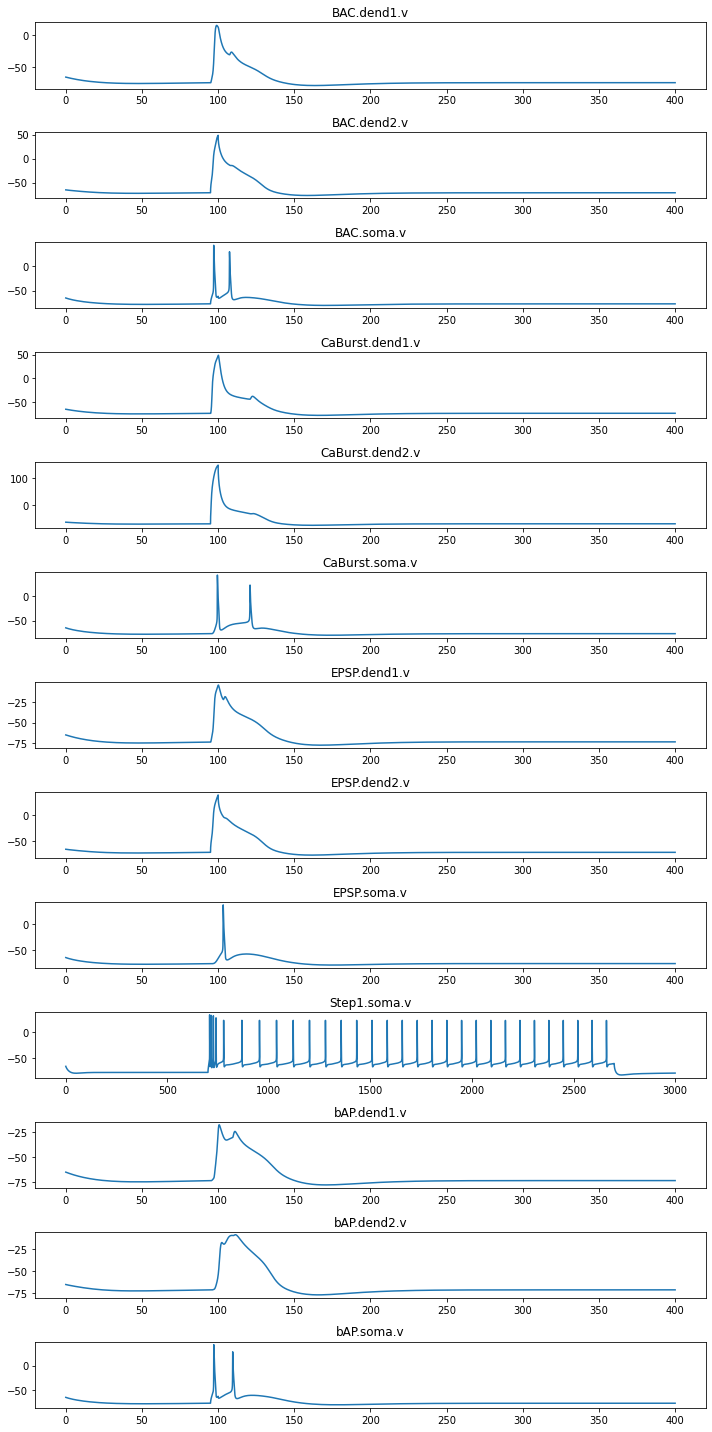

In [4]:
fig, axes = plt.subplots(len(responses), figsize=(10, 20), squeeze=False)
for index, (resp_name, response) in enumerate(sorted(responses.items())):
    axes[index, 0].plot(response['time'], response['voltage'], label=resp_name)
    axes[index, 0].set_title(resp_name)
fig.tight_layout()
fig.show()